# Modelado de la función sinusoidal con NeuralODEs

In [1]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions

Para esto tenémos que crear una ecuación diferencial parametrizada que me permita aprender la solución que buscamos. En este caso le damos a la NeuralODE una dinámica que es una combinación de funciones periódicas, con esto la NeuralODE debería ser capaz de entrenar los parámetros para poder llegar al resultado correcto.

In [2]:
function parametric_ode_system!(du,u,p,t)
    y = u
    ω, A, B = p
    du[1] = dy = A*cos(ω*2π*t) + B*sin(ω*2π*t)
  end;

Ahora seteamos el tiempo de simulación y los parámetros de la ecuación diferencial, como así la condición inicial del problema la cual es la posición inicial en 0.

In [3]:
tbegin = -1
tstep = 0.01
tend = 1
trange = tbegin:tstep:tend
p = ones(3)
tspan = (tbegin, tend)
u0 = [0.0];

Creamos el problema de ecuaciones diferenciales parametrizado. Además creamos lo que sería nuestra red neuronal que consiste en el resolvedor de ODEs.

In [4]:
prob = ODEProblem(parametric_ode_system!, u0, tspan, p)
function net()
    solve(prob, Tsit5(), p=p, saveat=trange)
end
sol = net()
x = vcat(sol.u...);

Generamos los datos de entrenamiento y datos de prueba de la función sinusoidal con ruido gaussiano

In [5]:
function sine_with_noise(t)
    return sin(2π*t) + rand(Normal(0,0.1))
end;

In [6]:
dataset_outs = [sine_with_noise.(trange)]
test_dataset = [sine_with_noise.(trange)];

Graficamos hora sí tanto solución de la ecuación diferencial como los datos de entrenamiento. Esto dependiendo de las condiciones iniciales aleatorias que se setearon puede estar cerca o lejos de la función sinusoidal con ruido

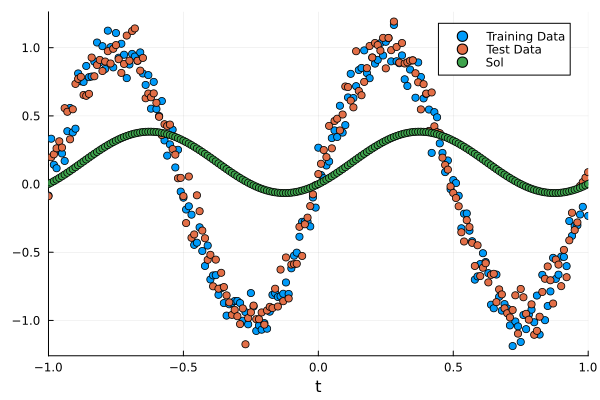

In [7]:
scatter(trange, dataset_outs, label = "Training Data")
scatter!(trange, test_dataset, label = "Test Data")
scatter!(sol, label = "Sol")

Creamos la función loss que es la diferencia entre la solución de la ecuación diferencial y los datos de entrenamiento

In [8]:
function loss_func()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, dataset_outs[1] .- pred)
  end;

In [9]:
function loss_func2()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, test_dataset[1] .- pred)
  end

loss_func2 (generic function with 1 method)

Creamos una función para ver la predicción de la red neuronal en cada época

In [10]:
function accuracy(y)
    num_correct = 0
    predictions = net()
    predictions = vcat(predictions.u...)
    for i in 1:length(predictions)
        if abs(predictions[i] - y[1][i]) < 0.2
            num_correct += 1
        end
    end
    return (num_correct/length(predictions)) * 100.0
end;

Ahora entrenamos la red durante 150 épocas con el método de optimización Adam y un learning rate de 0.1, además en cada época guardamos los datos del loss y la presición

In [11]:
epochs = 150
learning_rate = 0.1
data = Iterators.repeated((), epochs)
opt = ADAM(learning_rate)
iter = 0
losses = []
losses_test = []
accuracys = []
accuracys_test = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_func()
  println("Epoch: $iter | Loss: $actual_loss")
  push!(losses, actual_loss)
  push!(losses_test, loss_func2())
  push!(accuracys, accuracy(dataset_outs))
  push!(accuracys_test, accuracy(test_dataset))
  #plt = plot(solve(remake(prob, p=p), Tsit5()))
  #scatter!(trange, dataset_outs)
  #display(plt)
  #display(plot(solve(remake(prob,p=p),Tsit5()));
  #        scatter!(trange,dataset_outs))
end
fparams = Flux.params(p)

cb()

Flux.train!(loss_func, fparams, data, opt, cb=cb)

Epoch: 1 | Loss: 81.30519395593488
Epoch: 2 | Loss: 70.42375952895736
Epoch: 3 | Loss: 71.46969281449046
Epoch: 4 | Loss: 68.47982324690457
Epoch: 5 | Loss: 62.61238466783724
Epoch: 6 | Loss: 58.90557225787156
Epoch: 7 | Loss: 58.05202419817755
Epoch: 8 | Loss: 56.66123700588203
Epoch: 9 | Loss: 53.27365333709403
Epoch: 10 | Loss: 49.525572230203466
Epoch: 11 | Loss: 47.69803138435838
Epoch: 12 | Loss: 47.01017811454885
Epoch: 13 | Loss: 44.75405732482938


Epoch: 14 | Loss: 41.53337527934712
Epoch: 15 | Loss: 39.727451814859265
Epoch: 16 | Loss: 38.97954385056214
Epoch: 17 | Loss: 37.032704192164
Epoch: 18 | Loss: 34.29875228868012
Epoch: 19 | Loss: 32.85623702050093
Epoch: 20 | Loss: 32.03366472516504


Epoch: 21 | Loss: 29.867385407489994
Epoch: 22 | Loss: 27.875553492840474
Epoch: 23 | Loss: 27.122786069896986
Epoch: 24 | Loss: 25.683240530786684
Epoch: 25 | Loss: 23.685267664839674
Epoch: 26 | Loss: 22.834926898774828
Epoch: 27 | Loss: 21.75363928437797
Epoch: 28 | Loss: 20.000745640084332
Epoch: 29 | Loss: 19.254343328774773
Epoch: 30 | Loss: 18.242995060239377
Epoch: 31 | Loss: 16.79521034905421
Epoch: 32 | Loss: 16.236091876323613
Epoch: 33 | Loss: 15.139336594021225
Epoch: 34 | Loss: 14.12712883068108
Epoch: 35 | Loss: 13.612069242183072


Epoch: 36 | Loss: 12.491198336428619
Epoch: 37 | Loss: 11.970793543904984
Epoch: 38 | Loss: 11.198118363474453
Epoch: 39 | Loss: 10.458447532413699
Epoch: 40 | Loss: 10.00535494865082
Epoch: 41 | Loss: 9.192835174452984
Epoch: 42 | Loss: 8.863878238791349
Epoch: 43 | Loss: 8.134266685426436
Epoch: 44 | Loss: 7.813466082078655
Epoch: 45 | Loss: 7.214491882730885
Epoch: 46 | Loss: 6.891269770712682
Epoch: 47 | Loss: 6.39289973951585
Epoch: 48 | Loss: 6.094327994265181
Epoch: 49 | Loss: 5.666672735499657
Epoch: 50 | Loss: 5.41298643537506
Epoch: 51 | Loss: 5.025792157126664
Epoch: 52 | Loss: 4.82827664446279
Epoch: 53 | Loss: 4.47629865602915
Epoch: 54 | Loss: 4.324781903513249
Epoch: 55 | Loss: 4.018538939299945
Epoch: 56 | Loss: 3.876633669587394
Epoch: 57 | Loss: 3.651100111234158
Epoch: 58 | Loss: 3.48186384914251


Epoch: 59 | Loss: 3.3519935194076402
Epoch: 60 | Loss: 3.158939618765363
Epoch: 61 | Loss: 3.07837196714475
Epoch: 62 | Loss: 2.928655542049856
Epoch: 63 | Loss: 2.81639085752012
Epoch: 64 | Loss: 2.7495750802106422
Epoch: 65 | Loss: 2.6245635710440824
Epoch: 66 | Loss: 2.5576475744317757
Epoch: 67 | Loss: 2.501643969825243
Epoch: 68 | Loss: 2.4085943402243304
Epoch: 69 | Loss: 2.360702477792224
Epoch: 70 | Loss: 2.323708365746059
Epoch: 71 | Loss: 2.2573151954805315
Epoch: 72 | Loss: 2.214811859323116
Epoch: 73 | Loss: 2.1953675363898695
Epoch: 74 | Loss: 2.156665267340783
Epoch: 75 | Loss: 2.1153370346752047
Epoch: 76 | Loss: 2.0983166340611077
Epoch: 77 | Loss: 2.086163566936528
Epoch: 78 | Loss: 2.060180006302645
Epoch: 79 | Loss: 2.0349318833524426
Epoch: 80 | Loss: 2.02455177842508


Epoch: 81 | Loss: 2.0206932972184504
Epoch: 82 | Loss: 2.010679258248453
Epoch: 83 | Loss: 1.9952493421117858
Epoch: 84 | Loss: 1.9834366883809094
Epoch: 85 | Loss: 1.9793741421650257
Epoch: 86 | Loss: 1.979552883956725
Epoch: 87 | Loss: 1.978659823694174
Epoch: 88 | Loss: 1.9745105290065565
Epoch: 89 | Loss: 1.9684487658979635
Epoch: 90 | Loss: 1.9628143331528516
Epoch: 91 | Loss: 1.9591267707630478
Epoch: 92 | Loss: 1.9577018997043285
Epoch: 93 | Loss: 1.9580687312395493
Epoch: 94 | Loss: 1.9596576557947456
Epoch: 95 | Loss: 1.962287379856402
Epoch: 96 | Loss: 1.9662359700513685
Epoch: 97 | Loss: 1.9723543302251758
Epoch: 98 | Loss: 1.9829246854042617


Epoch: 99 | Loss: 2.001136044182651
Epoch: 100 | Loss: 2.036147269604974
Epoch: 101 | Loss: 2.0968913979691894
Epoch: 102 | Loss: 2.2115731930577693
Epoch: 103 | Loss: 2.363374166323029
Epoch: 104 | Loss: 2.550680554903425
Epoch: 105 | Loss: 2.522835687934146
Epoch: 106 | Loss: 2.300924852107254
Epoch: 107 | Loss: 2.0088068973113815
Epoch: 108 | Loss: 1.9863351579772481
Epoch: 109 | Loss: 2.1838420788150334
Epoch: 110 | Loss: 2.2805769112762686


Epoch: 111 | Loss: 2.1606128558999176
Epoch: 112 | Loss: 1.9777013734145583
Epoch: 113 | Loss: 1.9938594144009447
Epoch: 114 | Loss: 2.132771426954584
Epoch: 115 | Loss: 2.1474111700751095
Epoch: 116 | Loss: 2.031187977526379
Epoch: 117 | Loss: 1.956256241361681
Epoch: 118 | Loss: 2.017101333244586
Epoch: 119 | Loss: 2.0915431481294857
Epoch: 120 | Loss: 2.0525289911156896
Epoch: 121 | Loss: 1.9727061159259796
Epoch: 122 | Loss: 1.9639802827549855
Epoch: 123 | Loss: 2.0187846628155013
Epoch: 124 | Loss: 2.043510575110044
Epoch: 125 | Loss: 1.999904220117943
Epoch: 126 | Loss: 1.9580383925863407
Epoch: 127 | Loss: 1.968788692468765
Epoch: 128 | Loss: 2.0034501284072017
Epoch: 129 | Loss: 2.0095807306397493
Epoch: 130 | Loss: 1.9794811502730263
Epoch: 131 | Loss: 1.9562239709904703
Epoch: 132 | Loss: 1.9641338501725691
Epoch: 133 | Loss: 1.9852862168325704
Epoch: 134 | Loss: 1.990884301511612


Epoch: 135 | Loss: 1.974701199463381
Epoch: 136 | Loss: 1.9578944684699764
Epoch: 137 | Loss: 1.9570213689364968
Epoch: 138 | Loss: 1.9686771416565483
Epoch: 139 | Loss: 1.9777679716382297
Epoch: 140 | Loss: 1.9745779359641396
Epoch: 141 | Loss: 1.963976946729604
Epoch: 142 | Loss: 1.9559877222658972
Epoch: 143 | Loss: 1.956449930610723


Epoch: 144 | Loss: 1.962745598249884
Epoch: 145 | Loss: 1.9682350028262539
Epoch: 146 | Loss: 1.9686799669870325
Epoch: 147 | Loss: 1.9642125973888418
Epoch: 148 | Loss: 1.958639876248808
Epoch: 149 | Loss: 1.9554006069342074
Epoch: 150 | Loss: 1.955699909485694
Epoch: 151 | Loss: 1.9584470602024808


Una vez entrenada la NeuralODE, lo que hacemos es graficar los datos de entenamiento y los de la predicción de la red neuronal. Como se puede ver la red neuronal aprendió la función sinusoidal con ruido. Para esto lo que se logró es que los parámetros se actualicen de tal forma de que la solución de la ecuación diferencial se acerque a los datos de entrenamiento. Es por esto que volvemos a resovler el problema con los nuevos parámetros actualizados $p$

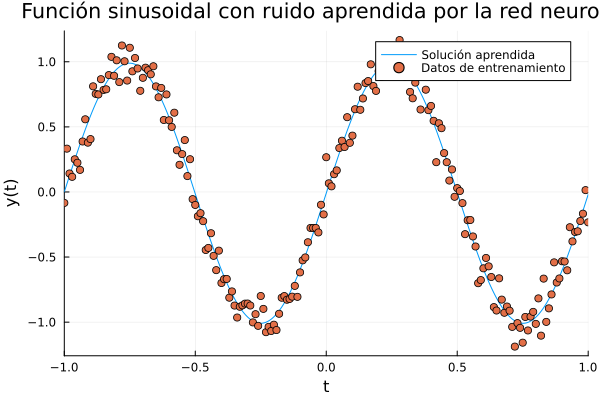

In [12]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal con ruido aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, dataset_outs, label = "Datos de entrenamiento")

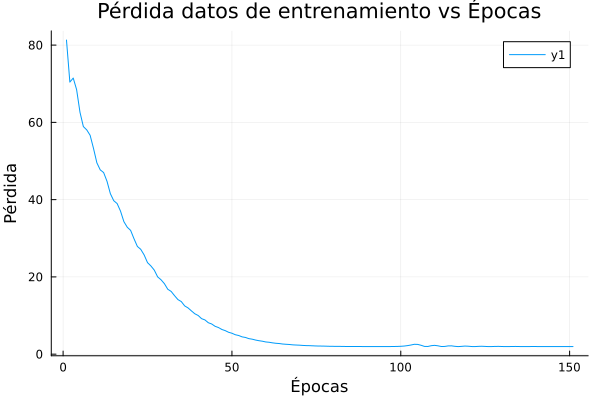

In [13]:
plot(losses, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de enetrenamiento: 96.51741293532339


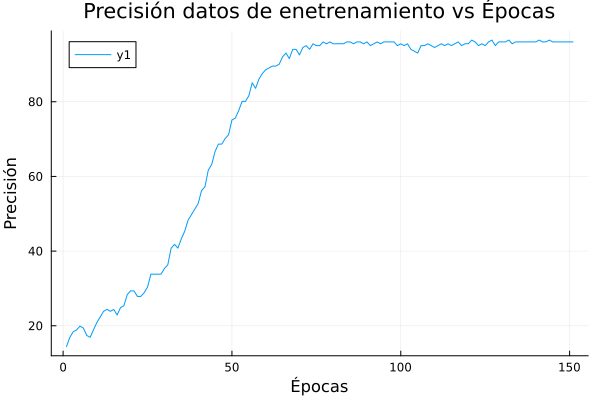

In [14]:
println("Maxima precisión en datos de enetrenamiento: ", maximum(accuracys))
plot(accuracys, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de enetrenamiento vs Épocas")

# Veamos con los datos de prueba

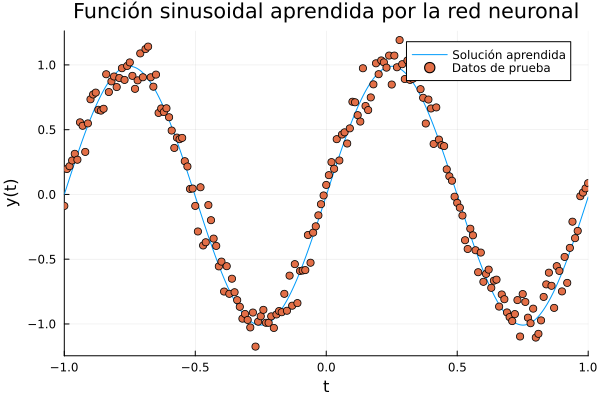

In [15]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, test_dataset, label = "Datos de prueba")

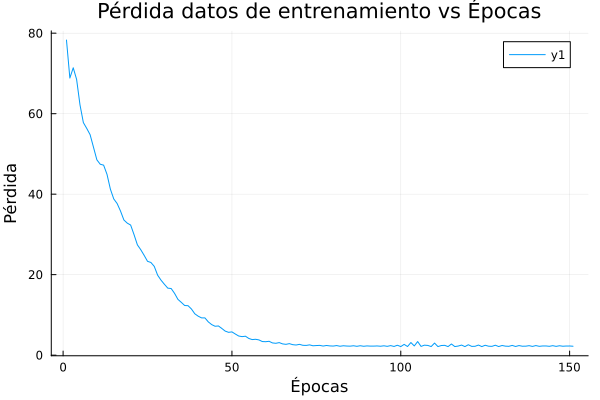

In [16]:
plot(losses_test, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de prueba: 96.51741293532339


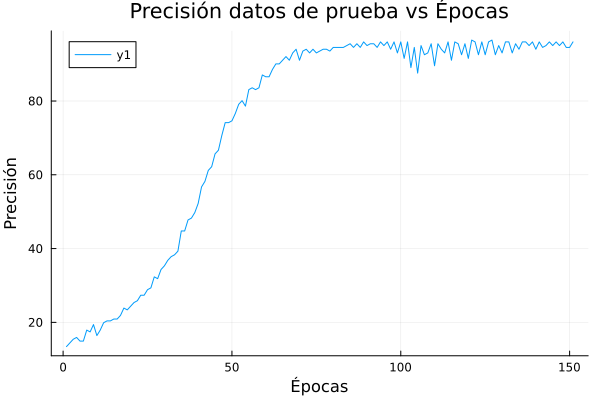

In [17]:
println("Maxima precisión en datos de prueba: ", maximum(accuracys_test))
plot(accuracys_test, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de prueba vs Épocas")

Como vemos esta NeuralODE comparada con los métodos anteriores mejora la presición en los datos de entrenamiento comparada con la red de varias capas que se creó con la red neuronal Feedfoward. Sin embargo esto depende mucho de las condiciones iniciales que se le de a la ecuación diferencial.